In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *

data_path = '../../AICity_data/train/S03/c010/'

In [8]:
def get_background_stats(videoPath, initFrame=1, lastFrame=514):
    vidcap = cv2.VideoCapture(videoPath)
    _, image = vidcap.read()

    ims_for_stats = lastFrame - initFrame + 1
    ims = np.zeros((ims_for_stats, image.shape[0], image.shape[1]))

    ims[0,:,:] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for frame in tqdm(range(initFrame, lastFrame)):
        _, image = vidcap.read()
        ims[frame,:,:] = (cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    means = np.mean(ims, axis=0)
    stds = np.std(ims, axis=0)
    return means, stds

In [9]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 514) # 514 is the 25% of the frames

100%|██████████| 513/513 [00:17<00:00, 29.58it/s]


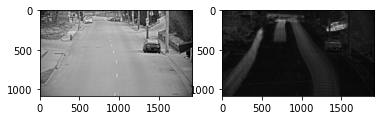

In [11]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(means, cmap='gray')
axs[1].imshow(stds, cmap='gray')

plt.show()

In [54]:
def cleanMask(mask, kernel_size=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size,kernel_size))
    # erosion_dst = cv2.erode(mask, element)
    # dilation = cv2.dilate(erosion_dst, element)

    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def getBoxesFromMask(mask):
    cleaned = cleanMask(mask, 7)
    output = cv2.connectedComponentsWithStats(np.uint8(cleaned), 8, cv2.CV_32S)
    (numLabels, labels, boxes, centroids) = output
    detectedElems = []
    for box in boxes[1:]: #First box is always the background
        if box[4] > 500: #Try to do a better estimation of the minimunm size
            # print(box)
            b = VehicleDetection(0, -1, float(box[0]), float(box[1]), float(box[2]), float(box[3]), float(-1))
            detectedElems.append(b)
            # tl = (int(b.xtl), int(b.ytl))
            # br = (int(b.xbr), int(b.ybr))
            # color = (255,0,0)
            # image = cv2.rectangle(image, tl, br, color, 2)
    return detectedElems

def remove_background(means, stds, videoPath, alpha=4, sigma=2):
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()

        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_mask = np.zeros(img_gray.shape)
        img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

        detections[str(frame)] = getBoxesFromMask(img_mask)

    return detections


In [46]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [52]:
singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi')

100%|██████████| 2140/2140 [02:55<00:00, 12.22it/s]


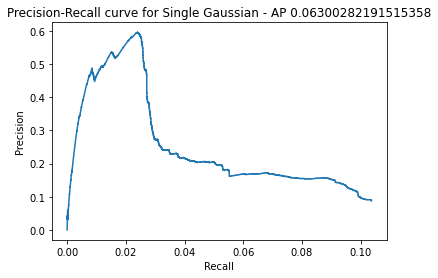

In [53]:
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Single Gaussian - AP {ap}')

In [55]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector', 520, 600)

 28%|██▊       | 601/2141 [00:05<00:12, 119.37it/s]


frames 81
